## Notebook to demonstrate unbinned unfolding using the boosted decision tree OmniFold
We will use six jet substructure observables based on the Z+jets dataset. We will use the Pythia data samples as the gen/particle-level and reconstructed Monte Carlo data. We will use the reconstructed Herwig samples as the pseudodata. The goal is to do unfolding with the Pythia and Herwig pseudodata to obtain the truth level Herwig samples.

In this notebook, we will do unbinned unfolding with NumPy arrays. We will demonstrate unfolding observable-by-observable (UniFold) and unfolding all observables simultaneously (MultiFold)

In [1]:
import energyflow as ef
import numpy as np
from helpers import get_substructure_obs
from omnifold import unbinned_omnifold, TH1_to_numpy, get_step2_predictions
import matplotlib.pyplot as plt
import ROOT

### Loading the data
Note the datasets each contain about 1.6 million samples. I have the number of samples set to 100k as a fast example.

In [2]:
num_total_data = 100000
num_train_data = 75000
num_test_data = 25000

In [3]:
dataset_pythia = ef.zjets_delphes.load('Pythia26', num_data=num_total_data, pad=True, cache_dir="./zjets_dataset",
                                               source='zenodo', which='all',
                                               include_keys=None, exclude_keys=None)
print("Loaded Pythia dataset.")
dataset_herwig = ef.zjets_delphes.load('Herwig', num_data=num_total_data, pad=True, cache_dir="./zjets_dataset",
                                               source='zenodo', which='all',
                                               include_keys=None, exclude_keys=None)
print("Loaded Herwig dataset.")

Loaded Pythia dataset.
Loaded Herwig dataset.


### Setting up all the histograms, response matrices, binning, and labels we'll need
The histograms+response matrices will be used when comparing to IBU. The binning and labels will also be used when making the final plots

In [4]:
# Note that observable_indices will be the index corresponding to the observable in the dataset for the next cell
observable_names = ["Mass", "Width", "Multiplicity", "SDMass", "zg", "Tau21"]
observable_indices, observable_binning, observable_pseudodata_hists, observable_responses, observable_labels = {}, {}, {}, {}, {}

for observable in observable_names:
    if observable == "Mass":
        observable_indices[observable] = 0
        observable_binning[observable] = (50, 0, 75)
        observable_pseudodata_hists[observable] = ROOT.TH1D("measured_mass_hist", "measured_mass_hist", 50, 0, 75)
        observable_responses[observable] = ROOT.RooUnfoldResponse(50, 0, 75)
        observable_labels[observable] = "Jet Mass $m$ [GeV]"
    elif observable == "Width":
        observable_indices[observable] = 1
        observable_binning[observable] = (50, 0, 0.6)
        observable_pseudodata_hists[observable] = ROOT.TH1D("measured_width_hist", "measured_width_hist", 50, 0, 0.6)
        observable_responses[observable] = ROOT.RooUnfoldResponse(50, 0, 0.6)
        observable_labels[observable] = "Jet Width $W$"
    elif observable == "Multiplicity":
        observable_indices[observable] = 2
        observable_binning[observable] = (80, 0, 80)
        observable_pseudodata_hists[observable] = ROOT.TH1D("measured_mult_hist", "measured_mult_hist", 80, 0, 80)
        observable_responses[observable] = ROOT.RooUnfoldResponse(80, 0, 80)
        observable_labels[observable] = "Jet Constituent Multiplicity $M$ [GeV]"
    elif observable == "SDMass":
        observable_indices[observable] = 3
        observable_binning[observable] = (50, -14, -2)
        observable_pseudodata_hists[observable] = ROOT.TH1D("measured_sdmass_hist", "measured_sdmass_hist", 50, -14, -2)
        observable_responses[observable] = ROOT.RooUnfoldResponse(50, -14, -2)
        observable_labels[observable] = "Soft Drop Jet Mass $ln \\rho$ "
    elif observable == "zg":
        observable_indices[observable] = 4
        observable_binning[observable] = (50, 0, 0.5)
        observable_pseudodata_hists[observable] = ROOT.TH1D("measured_zg_hist", "measured_zg_hist", 50, 0, 0.5)
        observable_responses[observable] = ROOT.RooUnfoldResponse(50, 0, 0.5)
        observable_labels[observable] = "Groomed Jet Momentum Fraction $z_{g}$"
    elif observable == "Tau21":
        observable_indices[observable] = 5
        observable_binning[observable] = (50, 0, 1.2)
        observable_pseudodata_hists[observable] = ROOT.TH1D("measured_tau21_hist", "measured_tau21_hist", 50, 0, 1.2)
        observable_responses[observable] = ROOT.RooUnfoldResponse(50, 0, 1.2)
        observable_labels[observable] = "N-subjettiness Ratio $\\tau_{21}^{(\\beta=1)}$"
    else:
        raise ValueError(f"{observable} is not a valid observable name.")

### Forming the substructure observables
We will also set up a pass_reco mask to demonstrate OmniFold with events that don't pass reconstruction.

In [5]:
reco_subs_pythia, gen_subs_pythia = get_substructure_obs(dataset_pythia)
pythia_pass_reco = dataset_pythia['sim_jets'][:,0]>150

reco_subs_herwig, gen_subs_herwig = get_substructure_obs(dataset_herwig)
herwig_pass_reco = dataset_herwig['sim_jets'][:,0]>150


pythia_gen_dict, pythia_reco_dict = {}, {}
herwig_gen_dict, herwig_reco_dict = {}, {}

for observable in observable_names:
    pythia_gen_dict[observable] = gen_subs_pythia[:, observable_indices[observable]]
    pythia_reco_dict[observable] = reco_subs_pythia[:, observable_indices[observable]]
    pythia_reco_dict["pass_reco"] = pythia_pass_reco
    
    herwig_gen_dict[observable] = gen_subs_herwig[:, observable_indices[observable]]
    herwig_reco_dict[observable] = reco_subs_herwig[:, observable_indices[observable]]
    herwig_reco_dict["pass_reco"] = herwig_pass_reco



### Filling the response matrices and histograms for IBU

In [6]:
for observable in observable_names:
    for (MCgen, MCreco, pass_reco) in zip(pythia_gen_dict[observable], pythia_reco_dict[observable], pythia_reco_dict["pass_reco"]):
        if pass_reco:
            observable_responses[observable].Fill(MCreco, MCgen)
        else:
            observable_responses[observable].Miss(MCgen)
    for (measured, pass_reco) in zip(herwig_reco_dict[observable], herwig_reco_dict["pass_reco"]):
        if pass_reco:
            observable_pseudodata_hists[observable].Fill(measured)
    

### Training the BDT models
We'll train both the UniFold and MultiFold models

In [7]:
num_iterations = 4

# Training UniFold models
for observable in observable_names:
    print(f"Unfolding {observable} with UniFold")
    _, _ = unbinned_omnifold(
        pythia_gen_dict[observable][:num_train_data],
        pythia_reco_dict[observable][:num_train_data], 
        herwig_reco_dict[observable][:num_train_data],
        num_iterations,
        MC_pass_reco_mask = pythia_reco_dict["pass_reco"][:num_train_data],
        measured_pass_reco_mask = herwig_reco_dict["pass_reco"][:num_train_data],
        save_models = True,
        model_save_name = f"unifold_{observable}",
        model_save_path = "./weights/"
    )

# Stacking the data for input to MultiFold
pythia_gen_multifold = np.stack([pythia_gen_dict[name] for name in observable_names], axis=1)
pythia_reco_multifold = np.stack([pythia_reco_dict[name] for name in observable_names], axis=1)
herwig_reco_multifold = np.stack([herwig_reco_dict[name] for name in observable_names], axis=1)

print("Unfolding with MultiFold")
# Training MultiFold model
_, _ = unbinned_omnifold(
    pythia_gen_multifold[:num_train_data],
    pythia_reco_multifold[:num_train_data], 
    herwig_reco_multifold[:num_train_data],
    num_iterations,
    MC_pass_reco_mask = pythia_reco_dict["pass_reco"][:num_train_data],
    measured_pass_reco_mask = herwig_reco_dict["pass_reco"][:num_train_data],
    save_models = True,
    model_save_name = "multifold",
    model_save_path = "./weights/"
    )


Unfolding Mass with UniFold
Saving models to existing path ./weights/
Starting iteration 1 step 1
Starting iteration 1 step 2
Starting iteration 2 step 1
Starting iteration 2 step 2
Starting iteration 3 step 1
Starting iteration 3 step 2
Starting iteration 4 step 1
Starting iteration 4 step 2
Unfolding Width with UniFold
Saving models to existing path ./weights/
Starting iteration 1 step 1
Starting iteration 1 step 2
Starting iteration 2 step 1
Starting iteration 2 step 2
Starting iteration 3 step 1
Starting iteration 3 step 2
Starting iteration 4 step 1
Starting iteration 4 step 2
Unfolding Multiplicity with UniFold
Saving models to existing path ./weights/
Starting iteration 1 step 1
Starting iteration 1 step 2
Starting iteration 2 step 1
Starting iteration 2 step 2
Starting iteration 3 step 1
Starting iteration 3 step 2
Starting iteration 4 step 1
Starting iteration 4 step 2
Unfolding SDMass with UniFold
Saving models to existing path ./weights/
Starting iteration 1 step 1
Starting 

### Get the BDT predictions on the test data and plot! We will compare the results to IBU

In [8]:
multifold_test_weights = get_step2_predictions(
    pythia_gen_multifold[-1*num_test_data:],
    model_save_directory = "./weights/",
    model_name = "multifold",
    iteration = num_iterations
)

Opening ./weights/multifold_iter4_step2.pkl for step 2 predictions.


Plotting Mass
Opening ./weights/unifold_Mass_iter4_step2.pkl for step 2 predictions.


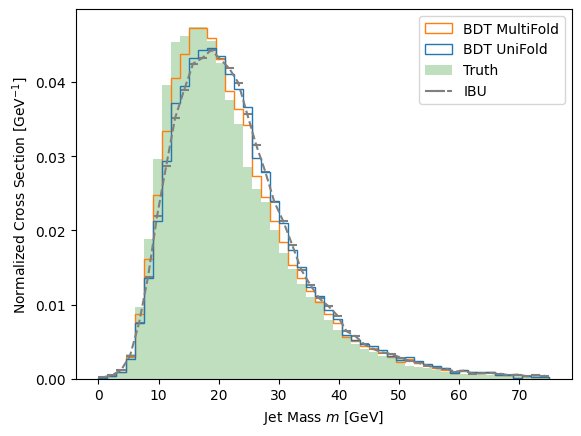

Plotting Width
Opening ./weights/unifold_Width_iter4_step2.pkl for step 2 predictions.


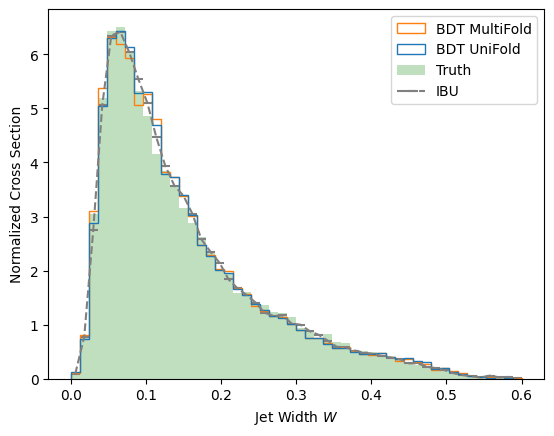

Plotting Multiplicity
Opening ./weights/unifold_Multiplicity_iter4_step2.pkl for step 2 predictions.


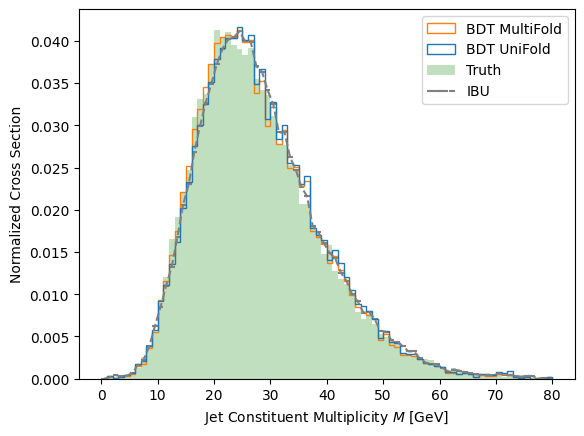

Plotting SDMass
Opening ./weights/unifold_SDMass_iter4_step2.pkl for step 2 predictions.


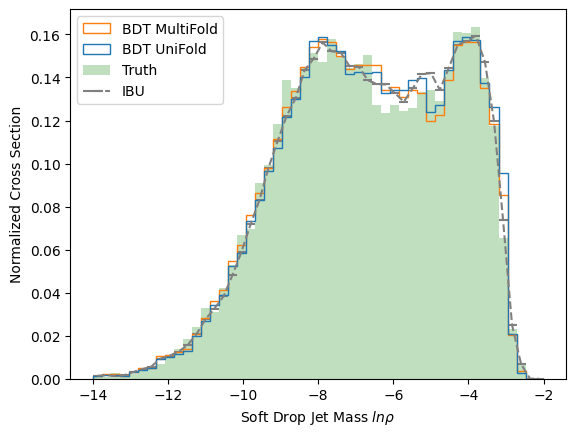

Plotting zg
Opening ./weights/unifold_zg_iter4_step2.pkl for step 2 predictions.


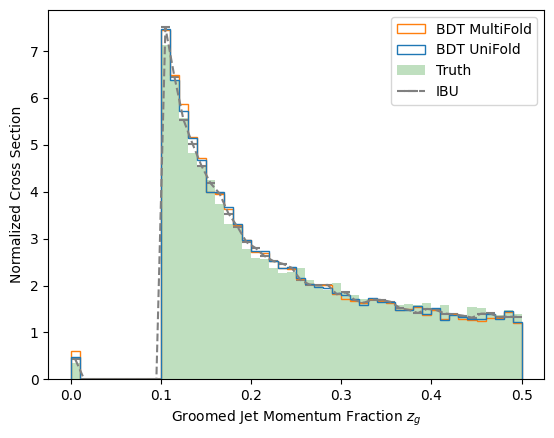

Plotting Tau21
Opening ./weights/unifold_Tau21_iter4_step2.pkl for step 2 predictions.


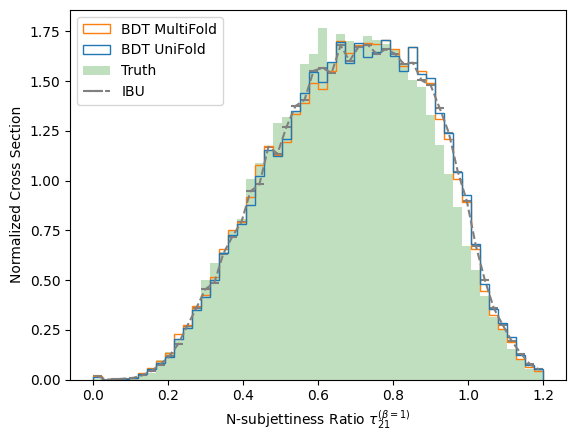

Using response matrix priors
Priors:

Vector (50)  is as follows

     |        1  |
------------------
   0 |9.0231e-05 
   1 |0.00030077 
   2 |0.00145372 
   3 |0.00559432 
   4 |0.0149282 
   5 |0.0302675 
   6 |0.0490556 
   7 |0.0646254 
   8 |0.075794 
   9 |0.0798745 
  10 |0.0815588 
  11 |0.0768066 
  12 |0.0717336 
  13 |0.0647658 
  14 |0.0575974 
  15 |0.0509504 
  16 |0.0426993 
  17 |0.0356613 
  18 |0.0304981 
  19 |0.0252547 
  20 |0.0218459 
  21 |0.0182467 
  22 |0.014838 
  23 |0.0127627 
  24 |0.0107876 
  25 |0.00977502 
  26 |0.00841153 
  27 |0.00623596 
  28 |0.00567453 
  29 |0.00464188 
  30 |0.00388996 
  31 |0.00340873 
  32 |0.00308791 
  33 |0.00262672 
  34 |0.00205526 
  35 |0.00185475 
  36 |0.00155398 
  37 |0.00130334 
  38 |0.00120308 
  39 |0.000852182 
  40 |0.000982515 
  41 |0.000751925 
  42 |0.000731874 
  43 |0.00067172 
  44 |0.000561437 
  45 |0.000491258 
  46 |0.000330847 
  47 |0.000340873 
  48 |0.000280719 
  49 |0.000290744 

Now unfo

In [9]:
for i, observable in enumerate(observable_names):
    
    print(f"Plotting {observable}")

    # Getting weights from UniFold model for this observable
    unifold_step2_weights = get_step2_predictions(
        pythia_gen_dict[observable][-1*num_test_data:],
        model_save_directory = "./weights/",
        model_name = f"unifold_{observable}",
        iteration = num_iterations
    )

    # Getting normalized unfolded IBU distribution
    response = observable_responses[observable]
    IBU_RooUnfold = ROOT.RooUnfoldBayes(response, observable_pseudodata_hists[observable], num_iterations)
    IBU_unfolded_hist = IBU_RooUnfold.Hunfold();
    IBU_hist_array, IBU_bin_centers, IBU_bin_widths = TH1_to_numpy(IBU_unfolded_hist)
    normalized_IBU_array = IBU_hist_array / (IBU_bin_widths * sum(IBU_hist_array))

    # We will only consider the test data when plotting
    plt.figure()
    plt.errorbar(IBU_bin_centers, normalized_IBU_array, xerr = IBU_bin_widths/2, label="IBU", linestyle='dashed', color='gray')
    plt.hist(
        pythia_gen_multifold[-1*num_test_data:, i],
        weights = multifold_test_weights,
        bins = observable_binning[observable][0],
        range = (observable_binning[observable][1], observable_binning[observable][2]),
        label="BDT MultiFold",
        density=True,
        histtype='step',
        color='tab:orange'
    )
    plt.hist(
        pythia_gen_dict[observable][-1*num_test_data:],
        weights = unifold_step2_weights,
        bins = observable_binning[observable][0],
        range = (observable_binning[observable][1], observable_binning[observable][2]),
        label="BDT UniFold",
        density=True,
        histtype='step',
        color='tab:blue'
    )
    plt.hist(
        herwig_gen_dict[observable][-1*num_test_data:],
        bins = observable_binning[observable][0],
        range = (observable_binning[observable][1], observable_binning[observable][2]),
        label="Truth",
        density=True,
        color=(0.75, 0.875, 0.75),
    )
    plt.legend()
    plt.ylabel("Normalized entries")
    plt.xlabel(observable_labels[observable])
    plt.ylabel("Normalized Cross Section $[\mathrm{GeV}^{-1}]$" if observable=="Mass" else "Normalized Cross Section")
    plt.show()